# Соревнование по сентимент-анализу

*В этом соревновании вам предстоит прогнозировать по тексту отзыва его тональность: 1 - позитивная, 0 - негативная. В отличие от усложненной версии задачи, здесь вам не требуется самостоятельно собирать обучающую выборку - она есть в предоставляемых вам данных.*

## Загрузка библиотек

In [226]:
import gc
import warnings
from random import choice
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('Set2')

## 1. Загрузка данных

In [4]:
train = pd.read_csv('data/products_sentiment_train.tsv', names=['text', 'label'], header=0, sep='\t')

In [5]:
train.head()

,text,label
0,i downloaded a trial version of computer assoc...,1
1,the wrt54g plus the hga7t is a perfect solutio...,1
2,i dont especially like how music files are uns...,0
3,i was using the cheapie pail ... and it worked...,1
4,"you can manage your profile , change the contr...",1


In [19]:
train.shape

(1999, 2)

In [15]:
test = pd.read_csv('data/products_sentiment_test.tsv', header=0, sep='\t').drop('Id', axis=1)

In [16]:
test.head()

,text
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [20]:
test.shape

(500, 1)

## 2. Описательный анализ данных

In [22]:
train.describe()

,label
count,1999.000000
mean,0.636818
std,0.481037
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


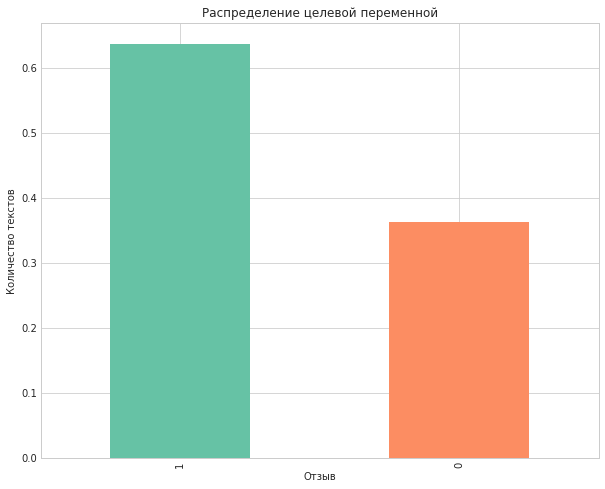

In [46]:
fig = plt.figure(figsize=(10, 8))
train['label'].value_counts(normalize=True).plot(kind='bar');
plt.title("Распределение целевой переменной");
plt.xlabel("Отзыв");
plt.ylabel("Количество текстов");

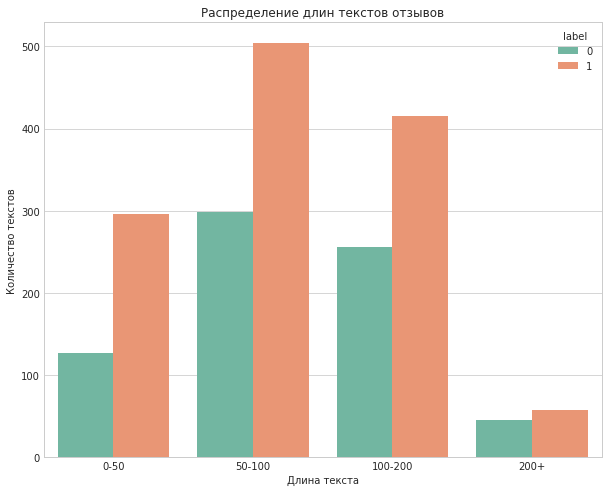

In [55]:
df = train.copy()
df['length'] = pd.cut(train['text'].apply(lambda x: len(x)), bins=[0, 50, 100, 200, float('inf')], 
       labels=['0-50', '50-100', '100-200', '200+'])

fig = plt.figure(figsize=(10, 8))
sns.countplot(x='length', hue='label', data=df);
plt.title("Распределение длин текстов отзывов");
plt.xlabel("Длина текста");
plt.ylabel("Количество текстов");

In [72]:
vectorizer = CountVectorizer()
token_matrix = vectorizer.fit_transform(X)
print(token_matrix.shape)

(2499, 3973)


In [74]:
transformer = TfidfTransformer()
frequency_counts = transformer.fit_transform(token_matrix)
print(frequency_counts.shape)

(2499, 3973)


In [75]:
pd.DataFrame(frequency_counts.A, columns=vectorizer.get_feature_names()).head()

,00,000,10,100,1000s,105,11,1100s,11b,12,...,zennx,zero,zone,zones,zoom,zoomed,zooming,zooms,zs,zx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Моделирование

Так как целевая переменная не сбалансирована, добавим 500 негативных отзывов в обучающую выборку.

In [61]:
train = shuffle(train.append(train.iloc[list(train[train['label'] == 0].index[:500])]), random_state=10)

In [62]:
train['label'].value_counts()

1    1273
0    1226
Name: label, dtype: int64

In [64]:
X = train['text'].values
y = train['label'].values

In [293]:
X_test = test['text'].values

In [127]:
stop_words =  stopwords.words('english')

In [143]:
params_grid_vectorizer = {
    'vectorizer__max_df' : [0.85, 0.9, 0.95, 1.0],
    'vectorizer__min_df' : [1, 10, 20], 
    'vectorizer__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)],
    'vectorizer__stop_words' : [stop_words, None, 'english']
}

### 3.1. Вспомогательные функции

In [77]:
def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', transformer),
            ('classifier', classifier)
        ])

In [206]:
def make_estimator(classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), classifier)
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, random_state=777, n_iter=100)
    grid_cv.fit(data, labels)
    return grid_cv

In [81]:
class DenseTransformer(TransformerMixin):
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

### 3.2. Линейные классификаторы

In [89]:
%%time
for name, clf in {'LogisticRegression': LogisticRegression, 'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier, 'RidgeClassifier': RidgeClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X, y, cv=5).mean()
    print(f"{name} - {score}")

LogisticRegression - 0.8175307901231607
LinearSVC - 0.8403444365777462
SGDClassifier - 0.8451364429457717
RidgeClassifier - 0.8327412173648694
CPU times: user 744 ms, sys: 4 ms, total: 748 ms
Wall time: 1.15 s


#### 3.2.1. Настройка параметров

In [175]:
params_grid_lr = {
    'classifier__C': np.arange(0.1, 2, 0.1),
    'classifier__max_iter': np.arange(50, 500, 50),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag']
}
params_grid_lsvc = {
    'classifier__loss': ['hinge', 'squared_hinge'], 
    'classifier__max_iter': np.arange(100, 1000, 50),
    'classifier__tol': [1e-5, 1e-4, 1e-3],
    'classifier__C': np.arange(0.1, 2, 0.1)
}
params_grid_sgdc = {
    'classifier__loss': ['log', 'hinge', 'modified_huber'], 
    'classifier__penalty':  ['l1', 'l2', 'elasticnet'], 
    'classifier__max_iter': np.arange(100, 1000, 50),
    'classifier__tol': np.arange(1e-5, 1e-3, 1e-5)
}
params_grid_rc = {
    'classifier__alpha': np.arange(0.1, 5, 0.1),
    'classifier__normalize': [True, False], 
    'classifier__tol': np.arange(1e-4, 1e-2, 1e-4),
    'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [207]:
%%time
grid_search_lr = make_estimator(LogisticRegression(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_lr}, 'accuracy', X, y)
print("LogisticRegression:")
print(f"Лучшее качество - {grid_search_lr.best_score_}")
print(f"Параметры - {grid_search_lr.best_params_}")

LogisticRegression:
Лучшее качество - 0.8651460584233693
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 6), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.95, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 450, 'classifier__C': 1.4000000000000001}
CPU times: user 1min 46s, sys: 24.9 s, total: 2min 11s
Wall time: 1min 23s


In [208]:
%%time
grid_search_lsvc = make_estimator(LinearSVC(random_state=777), 
                                  {**params_grid_vectorizer, **params_grid_lsvc}, 'accuracy', X, y)
print("LinearSVC:")
print(f"Лучшее качество - {grid_search_lsvc.best_score_}")
print(f"Параметры - {grid_search_lsvc.best_params_}")

LinearSVC:
Лучшее качество - 0.8703481392557023
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 5), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.9, 'classifier__tol': 0.001, 'classifier__max_iter': 400, 'classifier__loss': 'hinge', 'classifier__C': 1.9000000000000001}
CPU times: user 1min 10s, sys: 8 ms, total: 1min 10s
Wall time: 1min 10s


In [209]:
%%time
grid_search_sgdc = make_estimator(SGDClassifier(random_state=777), 
                                  {**params_grid_vectorizer, **params_grid_sgdc}, 'accuracy', X, y)
print("SGDClassifier:")
print(f"Лучшее качество - {grid_search_sgdc.best_score_}")
print(f"Параметры - {grid_search_sgdc.best_params_}")

SGDClassifier:
Лучшее качество - 0.860344137655062
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__tol': 0.0006200000000000001, 'classifier__penalty': 'l2', 'classifier__max_iter': 100, 'classifier__loss': 'modified_huber'}
CPU times: user 2min 13s, sys: 1.72 s, total: 2min 15s
Wall time: 1min 9s


In [210]:
%%time
grid_search_rc = make_estimator(RidgeClassifier(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_rc}, 'accuracy', X, y)
print("RidgeClassifier:")
print(f"Лучшее качество - {grid_search_rc.best_score_}")
print(f"Параметры - {grid_search_rc.best_params_}")

RidgeClassifier:
Лучшее качество - 0.8659463785514205
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 4), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.95, 'classifier__tol': 0.0015, 'classifier__solver': 'lsqr', 'classifier__normalize': False, 'classifier__alpha': 0.4}
CPU times: user 1min 21s, sys: 4 ms, total: 1min 21s
Wall time: 1min 21s


In [280]:
results_linear = {'LogisticRegression': (grid_search_lr.best_score_, grid_search_lr.best_params_),
                  'LinearSVC': (grid_search_lsvc.best_score_, grid_search_lsvc.best_params_),
                  'SGDClassifier': (grid_search_sgdc.best_score_, grid_search_sgdc.best_params_),
                  'RidgeClassifier': (grid_search_rc.best_score_, grid_search_rc.best_params_)}
print(f"Лучшая линейная модель - {max(results_linear, key=results_linear.get)}")
print(f"Лучшее качество - {max(results_linear.values())[0]}")
print(f"Параметры - {max(results_linear.values())[1]}")

Лучшая линейная модель - LinearSVC
Лучшее качество - 0.8703481392557023
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 5), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.9, 'classifier__tol': 0.001, 'classifier__max_iter': 400, 'classifier__loss': 'hinge', 'classifier__C': 1.9000000000000001}


### 3.3. Байесовские классификаторы

In [99]:
%%time
for name, clf in {'MultinomialNB': MultinomialNB, 'BernoulliNB': BernoulliNB, 
               'GaussianNB': GaussianNB}.items():
    if name == 'GaussianNB':
        score = cross_val_score(Pipeline([('vectorizer', CountVectorizer()), ('transformer', TfidfTransformer()),
                                  ('dense', DenseTransformer()), ('classifier', GaussianNB())]), X, y, cv=5).mean()
    else:
        score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf()), X, y, cv=5).mean()
    print(f"{name} - {score}")

MultinomialNB - 0.818346786987148
BernoulliNB - 0.8211475725902904
GaussianNB - 0.7046888923555693
CPU times: user 788 ms, sys: 48 ms, total: 836 ms
Wall time: 833 ms


#### 3.3.1. Настройка параметров

In [187]:
params_grid_mnb = {
    'classifier__alpha': np.logspace(0, 5, 100), 
    'classifier__fit_prior': [True, False]
}
params_grid_bnb = {
    'classifier__alpha': np.logspace(0, 5, 100),
    'classifier__fit_prior': [True, False]
}

In [211]:
%%time
grid_search_mnb = make_estimator(MultinomialNB(), 
                                {**params_grid_vectorizer, **params_grid_mnb}, 'accuracy', X, y)
print("MultinomialNB:")
print(f"Лучшее качество - {grid_search_mnb.best_score_}")
print(f"Параметры - {grid_search_mnb.best_params_}")

MultinomialNB:
Лучшее качество - 0.8631452581032413
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 5), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__fit_prior': True, 'classifier__alpha': 8.11130830789687}
CPU times: user 1min 20s, sys: 16 ms, total: 1min 20s
Wall time: 1min 20s


In [212]:
%%time
grid_search_bnb = make_estimator(BernoulliNB(), 
                                {**params_grid_vectorizer, **params_grid_bnb}, 'accuracy', X, y)
print("BernoulliNB:")
print(f"Лучшее качество - {grid_search_bnb.best_score_}")
print(f"Параметры - {grid_search_bnb.best_params_}")

BernoulliNB:
Лучшее качество - 0.771108443377351
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.9, 'classifier__fit_prior': False, 'classifier__alpha': 1.0}
CPU times: user 1min 21s, sys: 0 ns, total: 1min 21s
Wall time: 1min 21s


In [281]:
results_bayes = {'MultinomialNB': (grid_search_mnb.best_score_, grid_search_mnb.best_params_),
                 'BernoulliNB': (grid_search_bnb.best_score_, grid_search_bnb.best_params_)}
print(f"Лучшая байесовская модель - {max(results_bayes, key=results_bayes.get)}")
print(f"Лучшее качество - {max(results_bayes.values())[0]}")
print(f"Параметры - {max(results_bayes.values())[1]}")

Лучшая байесовская модель - MultinomialNB
Лучшее качество - 0.8631452581032413
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 5), 'vectorizer__min_df': 1, 'vectorizer__max_df': 1.0, 'classifier__fit_prior': True, 'classifier__alpha': 8.11130830789687}


### 3.4. Решающие деревья

In [101]:
%%time
for name, clf in {'DecisionTreeClassifier': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier, 
               'BaggingClassifier': BaggingClassifier, 'GradientBoostingClassifier': GradientBoostingClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=777)), X, y, cv=5).mean()
    print(f"{name} - {score}")

DecisionTreeClassifier - 0.7899395053580214
RandomForestClassifier - 0.7987371389485558
BaggingClassifier - 0.8007355229420916
GradientBoostingClassifier - 0.760710625242501
CPU times: user 7.78 s, sys: 0 ns, total: 7.78 s
Wall time: 7.78 s


#### 3.4.1. Настройка параметров

In [217]:
params_grid_dtc = {
    'classifier__max_depth': np.arange(1, 30, 1),
    'classifier__min_samples_split': np.arange(2, 6, 1),
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__min_impurity_decrease': np.logspace(-10, -6, 5)
}
params_grid_rfc = {
    'classifier__n_estimators': np.arange(1, 30, 1),
    'classifier__max_depth': [None] + list(np.arange(1, 30, 1)),
    'classifier__min_samples_split': np.arange(2, 6, 1),
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_impurity_decrease': np.logspace(-10, -6, 5)
}
params_grid_bc = {
    'classifier__n_estimators': np.arange(10, 1000, 10),
    'classifier__warm_start': [False, True], 
    'classifier__bootstrap_features': [False, True]
}
params_grid_gbc = {
    'classifier__n_estimators': np.arange(10, 1000, 10),
    'classifier__max_depth': [None] + list(np.arange(1, 30, 1)),
    'classifier__min_samples_split': np.arange(2, 6, 1),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__subsample': np.arange(0.6, 1, 0.1)
}

In [213]:
%%time
grid_search_dtc = make_estimator(DecisionTreeClassifier(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_dtc}, 'accuracy', X, y)
print("DecisionTreeClassifier:")
print(f"Лучшее качество - {grid_search_dtc.best_score_}")
print(f"Параметры - {grid_search_dtc.best_params_}")

DecisionTreeClassifier:
Лучшее качество - 0.7414965986394558
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 4), 'vectorizer__min_df': 20, 'vectorizer__max_df': 0.95, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 28}
CPU times: user 1min 43s, sys: 0 ns, total: 1min 43s
Wall time: 1min 43s


In [214]:
%%time
grid_search_rfc = make_estimator(RandomForestClassifier(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_rfc}, 'accuracy', X, y)
print("RandomForestClassifier:")
print(f"Лучшее качество - {grid_search_rfc.best_score_}")
print(f"Параметры - {grid_search_rfc.best_params_}")

RandomForestClassifier:
Лучшее качество - 0.7983193277310925
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 10, 'vectorizer__max_df': 1.0, 'classifier__n_estimators': 28, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_impurity_decrease': 1e-08, 'classifier__max_features': 'auto', 'classifier__max_depth': 28}
CPU times: user 1min 33s, sys: 0 ns, total: 1min 33s
Wall time: 1min 33s


In [215]:
%%time
grid_search_bc = make_estimator(BaggingClassifier(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_bc}, 'accuracy', X, y)
print("BaggingClassifier:")
print(f"Лучшее качество - {grid_search_bc.best_score_}")
print(f"Параметры - {grid_search_bc.best_params_}")

BaggingClassifier:
Лучшее качество - 0.8507402961184474
Параметры - {'vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'mor

In [218]:
%%time
grid_search_gbc = make_estimator(GradientBoostingClassifier(random_state=777), 
                                {**params_grid_vectorizer, **params_grid_gbc}, 'accuracy', X, y)
print("GradientBoostingClassifier:")
print(f"Лучшее качество - {grid_search_gbc.best_score_}")
print(f"Параметры - {grid_search_gbc.best_params_}")

GradientBoostingClassifier:
Лучшее качество - 0.8523409363745498
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.85, 'classifier__subsample': 0.8999999999999999, 'classifier__n_estimators': 510, 'classifier__min_samples_split': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}
CPU times: user 49min 44s, sys: 80 ms, total: 49min 44s
Wall time: 49min 44s


In [282]:
results_tree = {'DecisionTreeClassifier': (grid_search_dtc.best_score_, grid_search_dtc.best_params_),
                'RandomForestClassifier': (grid_search_rfc.best_score_, grid_search_rfc.best_params_),
                'BaggingClassifier': (grid_search_bc.best_score_, grid_search_bc.best_params_),
                'GradientBoostingClassifier': (grid_search_gbc.best_score_, grid_search_gbc.best_params_)}
print(f"Лучшая модель решающих деревьев - {max(results_tree, key=results_tree.get)}")
print(f"Лучшее качество - {max(results_tree.values())[0]}")
print(f"Параметры - {max(results_tree.values())[1]}")

Лучшая модель решающих деревьев - GradientBoostingClassifier
Лучшее качество - 0.8523409363745498
Параметры - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.85, 'classifier__subsample': 0.8999999999999999, 'classifier__n_estimators': 510, 'classifier__min_samples_split': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 14}


### 3.5. LightGBM

In [221]:
skf = StratifiedKFold(5)
skf.get_n_splits(X, y)

5

In [307]:
tfidf = TfidfVectorizer(ngram_range=(1, 5))
X_trans = tfidf.fit_transform(train['text'])
X_trans.shape

(2499, 98971)

In [263]:
accuracies_mean = []
accuracies_std = []
dict_list = []
for i in range(100):
    skf_split = skf.split(X, y)
    params_lgb = {'num_leaves': choice([27, 31, 61, 81, 127, 197, 231, 275, 302]),
                     'bagging_fraction': choice([0.5, 0.7, 0.8, 0.9]),
                     'learning_rate': choice([0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]),
                     'is_unbalance': choice([True, False]),
                     'max_bin': choice([3, 5, 10, 12, 18, 20, 22]),
                     'boosting_type': choice(['gbdt', 'dart']),
                     'bagging_freq': choice([3, 9, 11, 15, 17, 23, 31]),
                     'max_depth': choice([3, 4, 5, 6, 7, 9, 11]),
                     'feature_fraction': choice([0.5, 0.7, 0.8, 0.9]),
                     'lambda_l1': choice([0, 10, 20, 30, 40]),
                     'objective': 'binary',
                     'metric': 'binary_logloss'}
    accuracies = []
    
    print(f"Итерация №{i + 1}")
    for train_index, test_index in skf_split:
        X_train = X_trans[train_index]
        y_train = y[train_index]
        
        X_val = X_trans[test_index]
        y_val = y[test_index]
        
        lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=True)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train, free_raw_data=True)
        
        gbm = lgb.train(params_lgb,
                       lgb_train,
                       num_boost_round=10,
                       valid_sets=lgb_val,
                       early_stopping_rounds=5,
                       verbose_eval=5)
        y_pred_prob = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        y_pred = np.where(y_pred_prob > 0.5, 1, 0)
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
    
    accuracies_array = np.asarray(accuracies)
    accuracies_mean.append(accuracies_array.mean())
    accuracies_std.append(accuracies_array.std())
    dict_list.append(params_lgb)
    gc.collect()

Итерация №1
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.681989
[10]	valid_0's binary_logloss: 0.677306
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.679264
[10]	valid_0's binary_logloss: 0.674182
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.681248
[10]	valid_0's binary_logloss: 0.674424
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.680821
[10]	valid_0's binary_logloss: 0.673585
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.678595
[10]	valid_0's binary_logloss: 0.671473
Итерация №2
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692939
[10]	valid_0's binary_logloss: 0.692755
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692896
[10]	valid_0's binary_logloss: 0.692

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.684718
[10]	valid_0's binary_logloss: 0.679211
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.682817
[10]	valid_0's binary_logloss: 0.676441
Итерация №13
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692862
[10]	valid_0's binary_logloss: 0.692627
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692599
[10]	valid_0's binary_logloss: 0.692333
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692798
[10]	valid_0's binary_logloss: 0.692513
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692725
[10]	valid_0's binary_logloss: 0.692374
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692662
[10]	valid_0's binary_logloss: 0.692247
Итераци

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.69292
[10]	valid_0's binary_logloss: 0.692744
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692961
[10]	valid_0's binary_logloss: 0.692746
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692963
[10]	valid_0's binary_logloss: 0.692764
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692948
[10]	valid_0's binary_logloss: 0.692737
Итерация №25
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.687108
[10]	valid_0's binary_logloss: 0.68286
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.684863
[10]	valid_0's binary_logloss: 0.680243
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.686466
[10]	valid_0's binary_logloss: 0.680748
Training 

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.690992
[10]	valid_0's binary_logloss: 0.689568
Итерация №36
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.682768
[10]	valid_0's binary_logloss: 0.680818
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.6822
[10]	valid_0's binary_logloss: 0.680118
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.683852
[10]	valid_0's binary_logloss: 0.677716
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.684718
[10]	valid_0's binary_logloss: 0.678773
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.682817
[10]	valid_0's binary_logloss: 0.676668
Итерация №37
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.685945
[10]	valid_0's binary_logloss: 0.682

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.685234
[10]	valid_0's binary_logloss: 0.680751
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.684721
[10]	valid_0's binary_logloss: 0.681355
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.684271
[10]	valid_0's binary_logloss: 0.680558
Итерация №48
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.69269
[10]	valid_0's binary_logloss: 0.692182
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692331
[10]	valid_0's binary_logloss: 0.691954
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692557
[10]	valid_0's binary_logloss: 0.692099
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692647
[10]	valid_0's binary_logloss: 0.692184
Training

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.649157
[10]	valid_0's binary_logloss: 0.640328
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.641947
[10]	valid_0's binary_logloss: 0.620357
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.646453
[10]	valid_0's binary_logloss: 0.630972
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.650244
[10]	valid_0's binary_logloss: 0.632374
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.644608
[10]	valid_0's binary_logloss: 0.619749
Итерация №60
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.693072
[10]	valid_0's binary_logloss: 0.693015
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692989
[10]	valid_0's binary_logloss: 0.692909
Trainin

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692598
[10]	valid_0's binary_logloss: 0.692028
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692566
[10]	valid_0's binary_logloss: 0.69199
Итерация №71
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.688798
[10]	valid_0's binary_logloss: 0.685737
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.688329
[10]	valid_0's binary_logloss: 0.684844
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.688247
[10]	valid_0's binary_logloss: 0.684883
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.688669
[10]	valid_0's binary_logloss: 0.685022
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.687622
[10]	valid_0's binary_logloss: 0.683962
Итерация

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.674963
[10]	valid_0's binary_logloss: 0.671349
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.679952
[10]	valid_0's binary_logloss: 0.674138
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.679712
[10]	valid_0's binary_logloss: 0.675403
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.676065
[10]	valid_0's binary_logloss: 0.672887
Итерация №83
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692881
[10]	valid_0's binary_logloss: 0.692637
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692818
[10]	valid_0's binary_logloss: 0.692526
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.692846
[10]	valid_0's binary_logloss: 0.692563
Trainin

Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.689634
[10]	valid_0's binary_logloss: 0.68755
Итерация №94
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.600442
[10]	valid_0's binary_logloss: 0.572143
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.596265
[10]	valid_0's binary_logloss: 0.568062
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.573367
[10]	valid_0's binary_logloss: 0.537516
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.556218
[10]	valid_0's binary_logloss: 0.531963
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.574935
[10]	valid_0's binary_logloss: 0.551485
Итерация №95
Training until validation scores don't improve for 5 rounds.
[5]	valid_0's binary_logloss: 0.688761
[10]	valid_0's binary_logloss: 0.68

In [303]:
lgb_preds = pd.DataFrame({'acc_mean': accuracies_mean,
                          'acc_std': accuracies_std,
                         'params': dict_list}).sort_values('acc_mean', ascending=False).head()

In [304]:
for i, row in enumerate(lgb_preds.itertuples()):
    print(f"Модель №{i + 1}")
    print(f"Качество - {row.acc_mean} +- {row.acc_std}")
    print(f"Параметры - {row.params}", "\n")

Модель №1
Качество - 0.7142961195844784 +- 0.012998452280072447
Параметры - {'num_leaves': 61, 'bagging_fraction': 0.7, 'learning_rate': 0.3, 'is_unbalance': True, 'max_bin': 255, 'boosting_type': 'dart', 'bagging_freq': 9, 'max_depth': 11, 'feature_fraction': 0.8, 'lambda_l1': 0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': 1} 

Модель №2
Качество - 0.7058896907587631 +- 0.013293834856181163
Параметры - {'num_leaves': 27, 'bagging_fraction': 0.5, 'learning_rate': 0.5, 'is_unbalance': True, 'max_bin': 255, 'boosting_type': 'dart', 'bagging_freq': 3, 'max_depth': 9, 'feature_fraction': 0.9, 'lambda_l1': 0, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': 1} 

Модель №3
Качество - 0.7026912875651503 +- 0.01671677945223732
Параметры - {'num_leaves': 61, 'bagging_fraction': 0.9, 'learning_rate': 0.05, 'is_unbalance': True, 'max_bin': 255, 'boosting_type': 'gbdt', 'bagging_freq': 17, 'max_depth': 11, 'feature_fraction': 0.7, 'lambda_l1': 0, 'objective': 'binary

## 4. Предсказание

### 4.1. LinearSVC

In [291]:
svc = make_pipeline(CountVectorizer(min_df=1, ngram_range=(1, 5), max_df=0.9, stop_words=None),
                    TfidfTransformer(),
                    LinearSVC(max_iter=400, loss='hinge', C=1.9, tol=0.001, random_state=777))
svc.fit(X, y)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1,
        ngram_range=(1, 5), preprocessor=None, stop_words=None,
       ...inge', max_iter=400, multi_class='ovr',
     penalty='l2', random_state=777, tol=0.001, verbose=0))])

In [294]:
svc_pred = svc.predict(X_test)

In [296]:
with open('linear.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 500))).str.cat(map(str, svc_pred), sep=','), 
                                 columns=['Id,y']).to_csv(sep=' ', index=False))

### 4.2. MultinomialNB

In [297]:
mnb = make_pipeline(CountVectorizer(min_df=1, ngram_range=(1, 5), max_df=1, stop_words=None),
                    TfidfTransformer(),
                    MultinomialNB(alpha=8.11130830789687, fit_prior=True))
mnb.fit(X, y)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1, max_features=None, min_df=1,
        ngram_range=(1, 5), preprocessor=None, stop_words=None,
        s...idf=True)), ('classifier', MultinomialNB(alpha=8.11130830789687, class_prior=None, fit_prior=True))])

In [298]:
mnb_pred = mnb.predict(X_test)

In [299]:
with open('bayes.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 500))).str.cat(map(str, mnb_pred), sep=','), 
                                 columns=['Id,y']).to_csv(sep=' ', index=False))

### 4.3. GradientBoostingClassifier

In [300]:
gbc = make_pipeline(CountVectorizer(min_df=1, ngram_range=(1, 1), max_df=0.85, stop_words=None),
                    TfidfTransformer(),
                    GradientBoostingClassifier(subsample=0.9, n_estimators=510, min_samples_split=4, max_features='sqrt', max_depth=14))
gbc.fit(X, y)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.85, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
      ...      presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False))])

In [301]:
gbc_pred = gbc.predict(X_test)

In [302]:
with open('tree.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 500))).str.cat(map(str, gbc_pred), sep=','), 
                                 columns=['Id,y']).to_csv(sep=' ', index=False))

### 4.4. LightGBM

In [308]:
X_test_trans = tfidf.transform(test['text'])
X_test_trans.shape

(500, 98971)

In [312]:
weights = [0.4, 0.4, 0.1, 0.05, 0.05]
target = np.zeros(X_test_trans.shape[0])
for i, row in enumerate(lgb_preds.itertuples()):
    gbm = lgb.train(row.params, lgb.Dataset(X_trans, y), num_boost_round=10)
    lgb_pred = gbm.predict(X_test_trans)
    target = np.add(target, lgb_pred * weights[i])
    gc.collect()
target = np.where(target > 0.5, 1, 0)

In [313]:
with open('lgbm.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 500))).str.cat(map(str, target), sep=','), 
                                 columns=['Id,y']).to_csv(sep=' ', index=False))

## 5. Возможные улучшения

In [318]:
vectorizer_r = CountVectorizer(ngram_range=(1, 5))
X_r = vectorizer_r.fit_transform(X)
tfidf_r = TfidfTransformer()
freq_r = tfidf_r.fit_transform(X_r)
pca = PCA(n_components=2500, svd_solver='full')
pca.fit(pd.DataFrame(freq_r.A, columns=vectorizer_r.get_feature_names()))
reduced_pd = pca.transform(pd.DataFrame(freq_r.A, columns=vectorizer_r.get_feature_names()))

In [323]:
score = cross_val_score(LinearSVC(max_iter=400, loss='hinge', C=1.9, tol=0.001, random_state=777),
                      reduced_pd, y, scoring='accuracy', cv=5).mean()
print(f"LinearSVC + PCA - {score}")

LinearSVC + PCA - 0.8815677182708731


In [329]:
svc_pca = Pipeline([
            ('vectorizer', CountVectorizer(min_df=1, ngram_range=(1, 5), max_df=0.9, stop_words=None)),
            ('transformer', TfidfTransformer()),
            ('dense', DenseTransformer()),
            ('pca', PCA(n_components=2500, svd_solver='full')),
            ('classifier', LinearSVC(max_iter=400, loss='hinge', C=1.9, tol=0.001, random_state=777))
        ])

In [330]:
svc_pca.fit(X, y)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1,
        ngram_range=(1, 5), preprocessor=None, stop_words=None,
       ...inge', max_iter=400, multi_class='ovr',
     penalty='l2', random_state=777, tol=0.001, verbose=0))])

In [331]:
svc_pca_pred = svc_pca.predict(X_test)

In [332]:
with open('svc_pca.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 500))).str.cat(map(str, svc_pca_pred), sep=','), 
                                 columns=['Id,y']).to_csv(sep=' ', index=False))